In [1]:
import os
import re
import joblib
import pandas as pd
import numpy as np
import dateutil
from scipy import stats
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

In [2]:
date_parser = lambda x: dateutil.parser.parse(x, ignoretz=True)

In [3]:
dir_ann = '../RF/LOYSO/CV/'
models = sorted(os.listdir(dir_ann))

In [4]:
def xgb_predictions(X):
    predictions = {}
    for pkl_file in models:
        file_num = int(re.search(r'\d+', pkl_file).group())
        str_model = os.path.join(dir_ann, pkl_file)
        xgb = joblib.load(str_model)
        y_pred = xgb.predict(X)
        predictions[file_num] = y_pred

    new_df = pd.DataFrame(predictions)
    new_df = new_df[sorted(new_df.columns)]

    return new_df

In [5]:
# Load data
cs_file = '../data/SMB_input_2011_2015.csv'

df = pd.read_csv(cs_file,
   delimiter='\t', index_col=['Date/Time'],
    parse_dates=['Date/Time'], na_values='NAN',date_parser=date_parser)

In [7]:
X = (df.drop(['Diff', 'Event'], axis=1)).to_numpy()
y = (df['Diff'].copy()).to_numpy()

In [8]:
df_smb = xgb_predictions(X)

In [9]:
df_smb = df_smb.mean(axis=1).to_frame()
df_smb['OBS'] = y
df_smb.rename( columns={0 :'SIM'}, inplace=True )

In [10]:
x_aws = df_smb['OBS'].values
y_aws = df_smb['SIM'].values

In [11]:
slope_aws, intercept_aws, r_value_aws, p_value_aws, std_err_aws = stats.linregress(x_aws,y_aws)

In [12]:
print('r-squared:', r_value_aws**2)
print('RMSE:', np.sqrt(mean_squared_error(x_aws,y_aws)))
print('N:', len(y_aws))

r-squared: 0.9694169179166863
RMSE: 0.052743888804027805
N: 1037


In [13]:
# Calculate the point density
xy = np.vstack([x_aws,y_aws])
z_aws = gaussian_kde(xy)(xy)

In [14]:
dir_ann = '../RF/LOYSO_ERA5/CV/'
models = sorted(os.listdir(dir_ann))

In [15]:
# Load data
cs_file = '../data/SMB_input_2011_2016_ERA5.csv'

df = pd.read_csv(cs_file,
   delimiter='\t', index_col=['Date/Time'],
    parse_dates=['Date/Time'], na_values='NAN',date_parser=date_parser)

In [16]:
X = (df.drop(['Diff', 'Event'], axis=1)).to_numpy()
y = (df['Diff'].copy()).to_numpy()

In [17]:
df_smb = xgb_predictions(X)

In [18]:
df_smb = df_smb.mean(axis=1).to_frame()
df_smb['OBS'] = y
df_smb.rename( columns={0 :'SIM'}, inplace=True )

In [19]:
x_era = df_smb['OBS'].values
y_era = df_smb['SIM'].values

In [20]:
slope_era, intercept_era, r_value_era, p_value_era, std_err_era = stats.linregress(x_era,y_era)

In [21]:
print('r-squared:', r_value_era**2)
print('RMSE:', np.sqrt(mean_squared_error(x_era,y_era)))
print('N:', len(y_era))

r-squared: 0.9662882429098892
RMSE: 0.057889021458647265
N: 1131


In [22]:
# Calculate the point density
xy = np.vstack([x_era,y_era])
z_era = gaussian_kde(xy)(xy)

In [23]:
x_int = np.arange(-3,2,0.1)

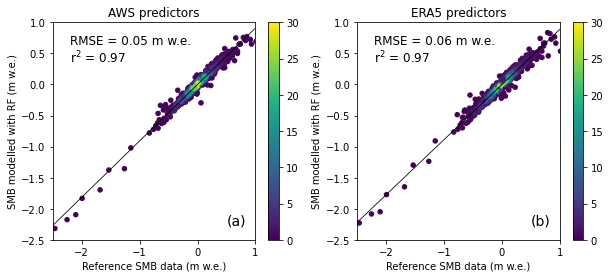

In [24]:
fig, (ax, ax1) = plt.subplots(1,2,figsize=(10,4))

density = ax.scatter(x_aws, y_aws, c=z_aws, s=20, vmin=0, vmax=30)
ax.plot(x_int, intercept_aws + slope_aws * x_int, linewidth=0.8, color='k', linestyle ='-')
fig.colorbar(density, ax=ax)
ax.set_title('AWS predictors')
ax.set_xlabel('Reference SMB data (m w.e.)')
ax.set_ylabel('SMB modelled with RF (m w.e.)')
ax.set_ylim(-2.5, 1)
ax.set_xlim(-2.5, 1)
ax.text(-2.2, 0.65,'RMSE'+' = '+str(round(np.sqrt(mean_squared_error(x_aws,y_aws)),2))+' '+'m w.e.', fontsize=12)
ax.text(-2.2, 0.35,'r$^{2}$'+' = '+str(round(r_value_aws**2,2)), fontsize=12)
ax.text(0.5, -2.25,'(a)', fontsize=14)

density = ax1.scatter(x_era, y_era, c=z_era, s=20, vmin=0, vmax=30)
ax1.plot(x_int, intercept_era + slope_era * x_int, linewidth=0.8, color='k', linestyle ='-')
fig.colorbar(density, ax=ax1)
ax1.set_title('ERA5 predictors')
ax1.set_xlabel('Reference SMB data (m w.e.)')
ax1.set_ylabel('SMB modelled with RF (m w.e.)')
ax1.set_ylim(-2.5, 1)
ax1.set_xlim(-2.5, 1)
ax1.text(-2.2, 0.65,'RMSE'+' = '+str(round(np.sqrt(mean_squared_error(x_era,y_era)),2))+' '+'m w.e.', fontsize=12)
ax1.text(-2.2, 0.35,'r$^{2}$'+' = '+str(round(r_value_era**2,2)), fontsize=12)
ax1.text(0.5, -2.25,'(b)', fontsize=14)


fig.savefig('../fig/scatter_plot_RF.png',dpi = 200, bbox_inches = 'tight', 
             pad_inches = 0.1, facecolor='w')